In [1]:
from os import listdir, path

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    InputLayer,
    BatchNormalization,
)

SIZE = 256

In [2]:
images = listdir(path.join('..', '..', 'dataset', 'original'))[::10]

X = np.zeros((len(images), SIZE, SIZE, 3))
Y = np.zeros((len(images), SIZE, SIZE, 3))

for i, image in tqdm(enumerate(images)):
    reconstructed = plt.imread(path.join('..', '..', 'dataset', 'reconstructed', image))
    original = plt.imread(path.join('..', '..', 'dataset', 'original', image))

    X[i] = reconstructed[:, :, :3]
    Y[i] = original[:, :, :3]

1368it [00:23, 57.18it/s]


In [3]:
X.nbytes / 2**30, Y.nbytes / 2**30

(2.00390625, 2.00390625)

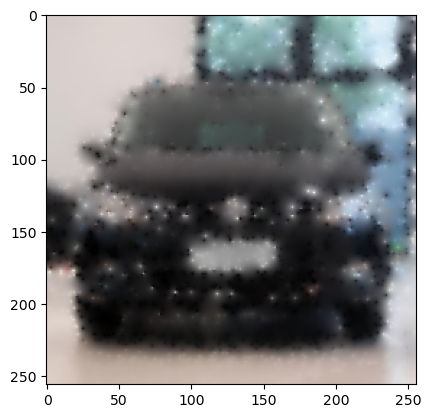

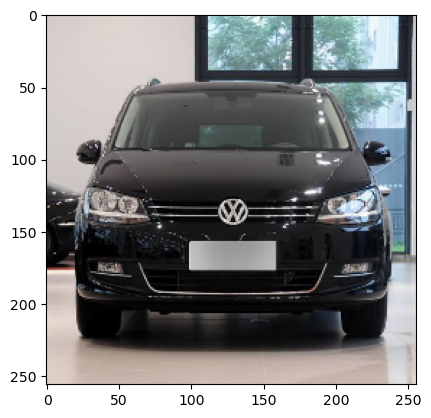

In [4]:
plt.imshow(X[42])
plt.show()
plt.imshow(Y[42])
plt.show()

In [5]:
def create_model():
    model = Sequential()
    model.add(InputLayer((SIZE, SIZE, 3)))

    # Encoder
    model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decorder
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(3, (5, 5), activation='sigmoid', padding='same'))

    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

In [6]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       1

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [8]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50)

Epoch 1/50
35/35 [==============================] - 36s 529ms/step - loss: 0.5491 - val_loss: 1.0771
Epoch 2/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5229 - val_loss: 0.6257
Epoch 3/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5182 - val_loss: 0.5897
Epoch 4/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5164 - val_loss: 0.5791
Epoch 5/50
35/35 [==============================] - 13s 372ms/step - loss: 0.5154 - val_loss: 0.5734
Epoch 6/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5145 - val_loss: 0.5631
Epoch 7/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5137 - val_loss: 0.5530
Epoch 8/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5128 - val_loss: 0.5399
Epoch 9/50
35/35 [==============================] - 13s 370ms/step - loss: 0.5121 - val_loss: 0.5323
Epoch 10/50
35/35 [==============================] - 13s 371ms/step - loss: 0.5111 - val_lo

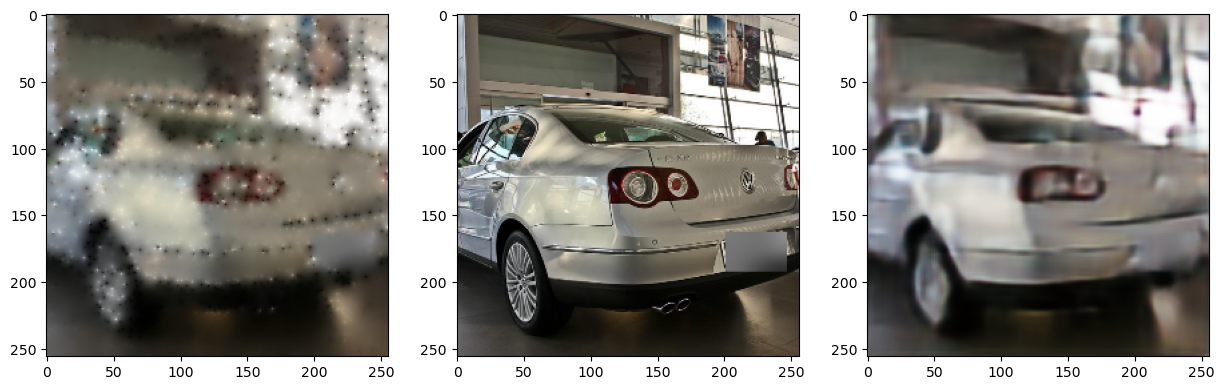

In [9]:
idx = 20

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(X_val[idx])
plt.subplot(1, 3, 2)
plt.imshow(Y_val[idx])
plt.subplot(1, 3, 3)
plt.imshow(model.predict(X_val[idx].reshape(1, SIZE, SIZE, 3)).squeeze())
plt.show()